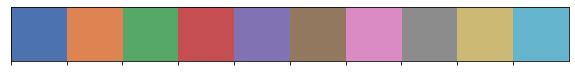

In [1]:
%matplotlib inline

import lsqfit
from model_averaging import *
from model_averaging.test_tmin import test_poly_tmin_SE

from model_averaging.stats import model_avg

In [2]:
p0_test_poly = {
    'a0': 1.80,
    'a1': -0.53,
    'a2': 0.00
}
obs_name='a0'
Nt = 16
correlated_data=False

def poly_model(x,p):
    return poly_model_lsqfit(x,p,Nt,m=2)

BAIC_perf: a_0 = 1.799(58)
BAIC_sub: a_0 = 1.765(94)


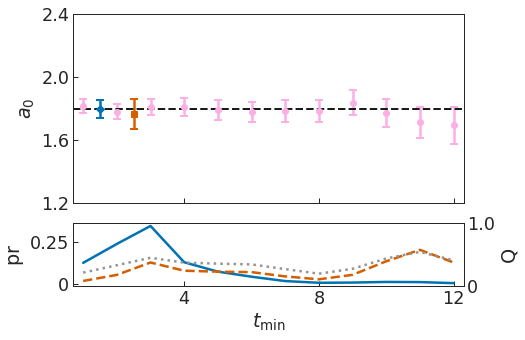

<AxesSubplot:xlabel='$\\log(N)$', ylabel='$a_0$'>

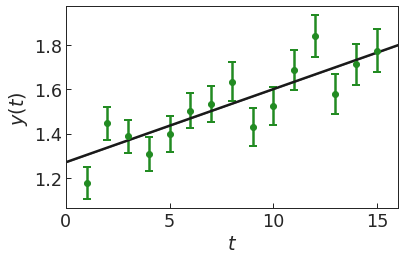

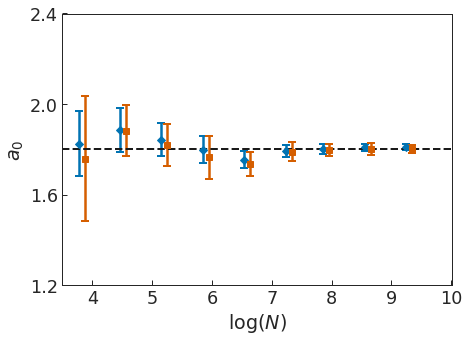

In [5]:
# Figures 1 and 2

# Toggle test cases
# k = 0 # Fig 2A
k = 1 # Fig 2B

## Scaling w/ number of samples
Nsamp_array = np.array([40, 80, 160, 320, 640, 1280, 2400, 4800, 9600])
Nsamp_max = Nsamp_array[-1]

# Set seed for consistency of outcome
np.random.seed(10284)

noise_params = {
    'frac_noise_amp': 1.0,
    'noise_floor_amp': 0.0,
    'noise_samples': Nsamp_max,
}
if correlated_data:
    scale_data = gen_synth_data_corr(
        np.arange(0,Nt), 
        p0_test_poly, 
        poly_model,
        rho=rho,
        **noise_params)    
else:
    scale_data = gen_synth_data(
        np.arange(0,Nt),                              
        p0_test_poly,
        poly_model,
        **noise_params)
    
IC_list = ['BAIC_perf', 'BAIC_sub']
fixed_list = []
fixed_tmin = {}

obs_est_vs_Nsamp={}
for est in IC_list + fixed_list:
    obs_est_vs_Nsamp.update({est: []})


for Nsamp in Nsamp_array:
    test_data_scale = cut_synth_data_Nsamp(scale_data, Nsamp)
    test_res_scale = test_poly_tmin_SE(test_data_scale, k=k, Nt=Nt, max_tmin=Nt-4, obs_name=obs_name,
                                       IC_list=IC_list)
    
    for IC in IC_list:
        obs_est_vs_Nsamp[IC].append(test_res_scale['obs_avg_IC'][IC])
    for fixed in fixed_list:
        obs_est_vs_Nsamp[fixed].append(test_res_scale['obs'][fixed_tmin[fixed]])
        
    if Nsamp==320:
        for IC in IC_list:
            print(IC + f": a_0 = {test_res_scale['obs_avg_IC'][IC]}")
            
        if k==0:
            plot_MA_result(test_res_scale, IC_list=IC_list, target_value=p0_test_poly[obs_name],
                           show_IC_ratios=False, ylim=[1.2,2.4])
            # Uncomment to save figure to disk
#             plt.savefig('subset_plots/fixed_N_k0.pdf', bbox_inches = "tight") # Fig 2A
        if k==1:
            plot_MA_result(test_res_scale, IC_list=IC_list, target_value=p0_test_poly[obs_name],
                           show_IC_ratios=False, ylim=[1.2,2.4], indv_plot_key='indv_1')
            # Uncomment to save figure to disk
#             plt.savefig('subset_plots/fixed_N_k1.pdf', bbox_inches = "tight") # Fig 2B
        
        plt.show()
        
        plot_gvcorr(test_res_scale['data']['y'], x=np.arange(1,Nt), color='forestgreen')

        

        TF = test_res_scale['fits'][2]
        plot_gvcorr(TF.fcn(np.arange(0,18), p0_test_poly), 
                    x=np.arange(0,18), color='k', fill=True)

        plt.xlabel('$t$')
        plt.ylabel('$y(t)$')
        plt.xlim(0,16)

        plt.tight_layout()
        
        # Uncomment to save figure to disk        
#         if k==1:
#             plt.savefig('subset_plots/data.pdf', bbox_inches = "tight") # Fig 1

plot_MA_result_scaling(obs_est_vs_Nsamp, Nsamp_array, IC_list=IC_list, fixed_list=fixed_list,
                       target_value=p0_test_poly[obs_name], indv_plot_key='indv', ylim=[1.2,2.4])
# Uncomment to save figure to disk
# if k==0:
#     plt.savefig('subset_plots/N_scaling_k0.pdf', bbox_inches = "tight")
# elif k==1:
#     plt.savefig('subset_plots/N_scaling_k1.pdf', bbox_inches = "tight")

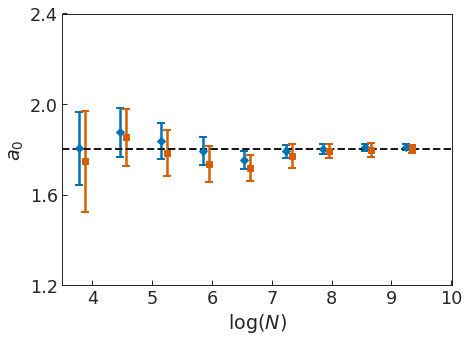

In [4]:
# Figure 3

## Scaling w/ number of samples - grand average

# Nsamp_array = np.array([40, 80, 160, 320, 640, 1280])
Nsamp_array = np.array([40, 80, 160, 320, 640, 1280, 2400, 4800, 9600])
Nsamp_max = Nsamp_array[-1]

np.random.seed(10284)

noise_params = {
    'frac_noise_amp': 1.0,
    'noise_floor_amp': 0.0,
    'noise_samples': Nsamp_max,
}
if correlated_data:
    scale_data = gen_synth_data_corr(
        np.arange(0,Nt), 
        p0_test_poly,
        poly_model,
        rho=rho,
        **noise_params)    
else:
    scale_data = gen_synth_data(
        np.arange(0,Nt), 
        p0_test_poly,
        poly_model,
        **noise_params)
    
    
IC_list = ['BAIC_perf', 'BAIC_sub']
fixed_list = []
fixed_tmin = {}

obs_est_vs_Nsamp_ga={}
for est in IC_list + fixed_list:
    obs_est_vs_Nsamp_ga.update({est: []})

for Nsamp in Nsamp_array:
    test_data_scale = cut_synth_data_Nsamp(scale_data, Nsamp)
    test_res_scale_const = test_poly_tmin_SE(test_data_scale, k=0, Nt=Nt, max_tmin=Nt-4, obs_name=obs_name,
                                             IC_list=IC_list)
    test_res_scale_line = test_poly_tmin_SE(test_data_scale, k=1, Nt=Nt, max_tmin=Nt-4, obs_name=obs_name,
                                            IC_list=IC_list)
    
    
    for IC in IC_list:
        ICs = np.concatenate((test_res_scale_const['IC'][IC], test_res_scale_line['IC'][IC]),axis=None)
        probs = np.exp(-(ICs-np.amin(ICs))/2)
        obs = np.concatenate((test_res_scale_const['obs'], test_res_scale_line['obs']),axis=None)
        
        obs_est_vs_Nsamp_ga[IC].append(model_avg(obs, probs))
        
plot_MA_result_scaling(obs_est_vs_Nsamp_ga, Nsamp_array, IC_list=IC_list, fixed_list=fixed_list, target_value=p0_test_poly[obs_name], ylim=[1.2,2.4])
# plt.text(0.45, 0.9, r'Grand avg, ${\rm SNR}_{\rm min} = $' + str(int(snr)), transform=ax.transAxes)

# Uncomment to save figure to disk
# plt.savefig('subset_plots/N_scaling_ga.pdf', bbox_inches = "tight") # Fig 3